<a href="https://colab.research.google.com/github/Cranjis-McB/NLP/blob/main/attention_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal

* Understand and Describe the Idea behind the Self-Attention Mechanism.
* Implement the Multihead Self-Attention Architecture in Pytorch from Scratch as described in [Attention Is All You Need](https://arxiv.org/abs/1706.03762).
* Implement the Encoder-Decoder Architecture in Pytorch from Scratch as described in [Attention Is All You Need](https://arxiv.org/abs/1706.03762).

## References:

* [Original Paper.](https://arxiv.org/abs/1706.03762)
* [Beautiful Blog on Transformers.](https://peterbloem.nl/blog/transformers)
* [Excellent Torch Implementation of the Transformer](https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch)
* [Amazing YouTube Tutorial on Transformer by Aladdin](https://www.youtube.com/watch?v=U0s0f995w14&t=2101s)

## The Idea

**What is Self Attention?**

* Self-Attention is a Sequence to Sequence operation where each output is a weighted sum of all the input sequence. (Maybe that's how output sequence at each time stamp (or location) has the contextual information about all the inputs sequence.)

* To put it mathematically, Let's consider k-dimensional input sequence $x_{1}$, $x_{2}$,..., $x_{n}$ and after applying self-attention we get k-dimensional output sequence  $y_{1}$, $y_{2}$,..., $y_{n}$. The relation between $y_{i}$ and input sequence x is as follows:

\begin{align}
y_{i} = \sum_{j=1}^n W_{ij} x_j
\end{align}

where 
\begin{align}
W_{ij}^{'} = x_{i}^T x_j
\end{align}

The dot product can ranges anywhere from negative infinity to Positive infinity so we apply a softmax to map the values to [0,1] and to ensure that they sum to 1 over the whole sequence:

\begin{align}
W_{ij} = \frac{exp(W_{ij}^{'})}{\sum_{j=1}^n exp(W_{ij}^{'})}
\end{align}

Note that there are **no trainable parameters** (or weights) in above equations.

**Adding trainable parameters to Self-Attention:**

* Deep learning is all about introducing trainable parameters to the architecture in a sensible way and learning them based on data (inputs, labels) and cost function.

* Let's add trainable parameters to the idea of self-attention mentioned above. 

* According to the paper, Author introduced 3 sets of parameters to the Self-Attention namely **Key, Query, and Value**.

* The input sequence is multiplied with these 3 Parameters and Outputs are calculated as followings:

\begin{align}
q_{i} = W_{q}x_{i}, \\ 
k_{i}=W_{k}x_{i}, \\
v_{i} = W_{v}x_{i}
\end{align}

then $W_{ij}$ (in above equation) is calculated in this manner:

\begin{align}
W_{ij}^{'} = q_{i}^T k_j 
\\ W_{ij} = softmax(W_{ij}^{'})
\end{align}

and finally, we calculate output $y_{i}$ using:

\begin{align}
y_{i} = \sum_{j=1}^n W_{ij} v_j
\end{align}

Note that $W_{q}$, $W_{k}$, and $W_{v}$ are trainable parameters here.

**What is Multihead Self Attention?**

* The above is single-head Self Attention.
* In Multihead self-attention, we have multiple sets of Key, Query, and Value. for ex. 4-head self attention, there are 4 different sets of Key, Query, and Values.
* And we follows the above process 4 (num of heads) times, and concatenates the 4 outputs to have the final output.
* In order to have the Input and Output Sequence of the same length, We make sure that **Dimension of the Input Sequence is divided by the num. of heads.**


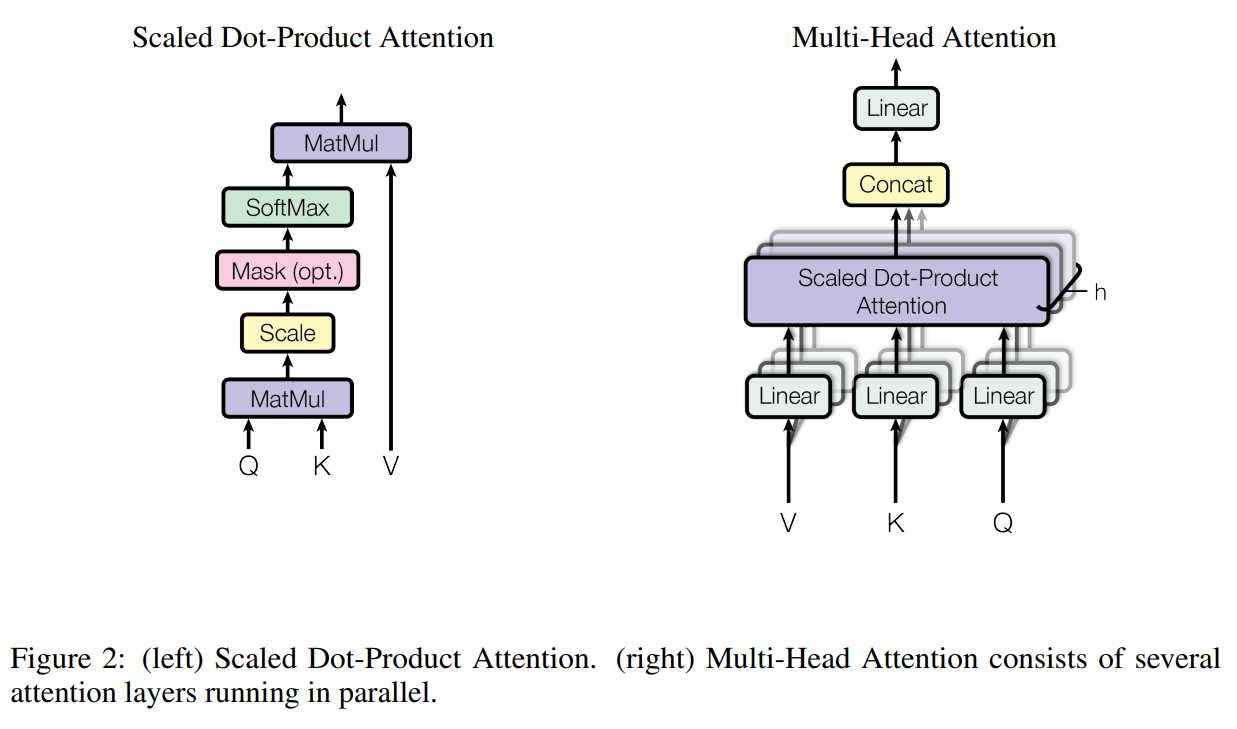

## Self-Attention

In [36]:
''' 
  Multihead Self Attention Class.
  Class Input: Embedding dimension, num_of_heads
'''

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiheadSelfAttention(nn.Module):
  
  def __init__(self, embed_dim, n_heads): 
    super(MultiheadSelfAttention, self).__init__()

    self.embed_dim = embed_dim
    self.n_heads = n_heads
    self.head_dim = self.embed_dim//self.n_heads

    assert (self.n_heads * self.head_dim == self.embed_dim), 'Embeddeing Dim should be divisible by number of heads'

    self.key_matrix = nn.Linear(embed_dim, embed_dim)
    self.query_matrix = nn.Linear(embed_dim, embed_dim)
    self.value_matrix = nn.Linear(embed_dim, embed_dim)
    self.fc = nn.Linear(embed_dim, embed_dim)

  def forward(self, key, query, value, mask): # 32 x 10 x 512

    batch_size = key.shape[0] # 32
    key_len, query_len, value_len = key.shape[1], query.shape[1], value.shape[1] # 10

    # Projection
    key = self.key_matrix(key) # 32 x 10 x 512
    query = self.query_matrix(query)
    value =  self.value_matrix(value)

    # Reshape key, query, and values.
    key = key.reshape(batch_size, key_len, self.n_heads, self.head_dim) # 32 x 10 x 8 x 64
    query = query.reshape(batch_size, query_len, self.n_heads, self.head_dim) # 32 x 10 x 8 x 64
    value = value.reshape(batch_size, value_len, self.n_heads, self.head_dim) # 32 x 10 x 8 x 64

    # Product query x key.T
    product = torch.einsum('nqhd, nkhd -> nhqk', [query, key]) # 32 x 8 x 10 x 10

    if mask is not None:
      product = product.masked_fill(mask == 0, float("-1e20"))

    # Attention weights
    attention = torch.softmax(product/(self.embed_dim ** (1/2)), dim=3)

    # Output
    out = torch.einsum('nhql, nlhd -> nqhd', [attention, value]).reshape(
        batch_size, query_len, self.head_dim * self.n_heads
        ) # 32 x 10 x 512

    out = self.fc(out) # 32 x 10 x 512

    return out

In [37]:
# Test
mha = MultiheadSelfAttention(512, 8)
key = query = value = torch.randn(32, 10, 512)
out = mha(key, query, value, None)
print(out.shape)

torch.Size([32, 10, 512])


## Transformer Block

In [38]:
class TransformerBlock(nn.Module):

  def __init__(self, 
               embed_dim, 
               n_heads, 
               dropout, 
               forward_expansion
               ):
    super(TransformerBlock, self).__init__()
    
    self.attention = MultiheadSelfAttention(embed_dim, n_heads)
    self.layernorm1 = nn.LayerNorm(embed_dim)
    self.layernorm2 = nn.LayerNorm(embed_dim)
    self.feed_forward = nn.Sequential(nn.Linear(embed_dim, embed_dim * forward_expansion), 
                                      nn.ReLU(), 
                                      nn.Linear(embed_dim * forward_expansion, embed_dim)
                                      )
    self.drop = nn.Dropout(dropout)

  def forward(self, key, query, value, mask):
    
    attention = self.attention(key, query, value, mask)
    x =  self.drop(self.layernorm1(attention + query))
    y =  self.drop(self.layernorm2(self.feed_forward(x) + x))

    return y

In [39]:
# Test
tformer = TransformerBlock(512, 8, 0.2, 4)
key = query = value = torch.randn(32, 10, 512)
out = tformer(key, query, value, None)
print(out.shape)

torch.Size([32, 10, 512])


## Encoder

In [40]:
class Encoder(nn.Module):

  def __init__(self, 
               src_vocab_size, 
               embed_dim, 
               n_heads, 
               n_layers,
               dropout, 
               forward_expansion, 
               max_len, 
               device
               ):
    super(Encoder, self).__init__()

    self.device = device
    self.word_embed = nn.Embedding(src_vocab_size, embed_dim)
    self.pos_embed = nn.Embedding(max_len, embed_dim)
    self.layers = nn.ModuleList([TransformerBlock(embed_dim, n_heads, dropout, forward_expansion) for _ in range(n_layers)])
    self.drop = nn.Dropout(dropout)

  def forward(self, x, mask): # 32 x 10 (batch_size x seq_len)
    
    N, seq_len = x.shape
    positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
    out = self.drop(self.word_embed(x) + self.pos_embed(positions)) # 32 x 10 x 512
    for layer in self.layers:
      out = layer(out, out, out, mask)

    out = self.drop(out)

    return out

In [41]:
# Test
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = Encoder(100, 512, 8, 4, 0.2, 4, 10, device)
x = torch.randint(10, size=(32, 10))
out = encoder(x, None)
print(out.shape)

torch.Size([32, 10, 512])


## Decoder

In [42]:
class DecoderBlock(nn.Module):
  def __init__(self, 
               embed_dim, 
               n_heads, 
               forward_expansion, 
               dropout
               ):
    super(DecoderBlock, self).__init__()

    self.attention = MultiheadSelfAttention(embed_dim, n_heads)
    self.layernorm = nn.LayerNorm(embed_dim)
    self.tformer = TransformerBlock(embed_dim, n_heads, dropout, forward_expansion)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, key, value, src_mask, trg_mask):
    
    attention = self.attention(x, x, x, trg_mask)
    query = self.dropout(self.layernorm(attention + x))
    out = self.tformer(key, query, value, src_mask)

    return out

In [43]:
class Decoder(nn.Module):
  def __init__(self, 
               trg_vocab_size, 
               embed_dim, 
               n_heads, 
               n_layers,
               forward_expansion, 
               dropout, 
               device, 
               max_len
               ):
    super(Decoder, self).__init__()
    self.device = device
    self.word_embed = nn.Embedding(trg_vocab_size, embed_dim)
    self.pos_embed = nn.Embedding(max_len, embed_dim)
    self.layers = nn.ModuleList([DecoderBlock(embed_dim, n_heads, forward_expansion, dropout) for _ in range(n_layers)])
    self.fc_out = nn.Linear(embed_dim, trg_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, enc_out, src_mask, trg_mask):
    
    N, seq_len = x.shape
    positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
    x = self.dropout(self.word_embed(x) + self.pos_embed(positions))

    for layer in self.layers:
      x = layer(x, enc_out, enc_out, src_mask, trg_mask)

    out = self.fc_out(x)

    return out

## Transformer

In [44]:
class Transformer(nn.Module):
  def __init__(self, 
               src_vocab_size, 
               trg_vocab_size, 
               src_pad_idx, 
               trg_pad_idx,
               embed_dim = 256, 
               n_heads = 8, 
               n_layers = 6, 
               forward_expansion = 4, 
               dropout = 0, 
               device = 'cpu', 
               max_len = 100
               ):
    super(Transformer, self).__init__()
    self.device = device
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx

    self.encoder = Encoder(src_vocab_size, 
                           embed_dim, 
                           n_heads, 
                           n_layers, 
                           dropout, 
                           forward_expansion, 
                           max_len, 
                           device
                           )
    self.decoder = Decoder(trg_vocab_size, 
                           embed_dim, 
                           n_heads, 
                           n_layers, 
                           forward_expansion, 
                           dropout, 
                           device, 
                           max_len
                           )
  
  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return src_mask.to(self.device)

  def make_trg_mask(self, trg):
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(N, 1, trg_len, trg_len)
    return trg_mask.to(self.device)

  def forward(self, src, trg):

    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_out = self.encoder(src, src_mask)
    out = self.decoder(trg, enc_out, src_mask, trg_mask)

    return out

## Test

In [45]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(
        device
    )
    trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

    src_pad_idx = 0
    trg_pad_idx = 0
    src_vocab_size = 10
    trg_vocab_size = 10
    model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(
        device
    )
    out = model(x, trg[:, :-1])
    print(out.shape)

cpu
torch.Size([2, 7, 10])
